# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [ ]:
env = UnityEnvironment(file_name="gym/Tennis.app", base_port=64738, worker_id=3, seed=0, no_graphics=False)

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [ ]:
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim
import sys 
from scripts.model import Actor, Critic
from scripts.agent import Agent
import time
import copy
from matplotlib.pylab import plt
%load_ext autoreload
%autoreload 2

In [2]:
TRAIN = 1
print("Train : {}".format(TRAIN))

gym_name = "Crawler"
env_name = "gym/" + gym_name + ".app"
score_thr = 400
break_thr = 10

env = UnityEnvironment(file_name=env_name, base_port=64738, worker_id=3, seed=0, no_graphics=True)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Train : 1
Mono path[0] = '/Users/raminanushiravani/Desktop/courses/deep-reinforcement-learning/p3_collab-compet/gym/Crawler.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/raminanushiravani/Desktop/courses/deep-reinforcement-learning/p3_collab-compet/gym/Crawler.app/Contents/MonoBleedingEdge/etc'


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: CrawlerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 129
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 20
        Vector Action descriptions: , , , , , , , , , , , , , , , , , , , 


Number of agents: 12
Size of each action: 20
There are 12 agents. Each observes a state with length: 129
The state for the first agent looks like: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.25000000e+00
  1.00000000e+00  0.00000000e+00  1.78813934e-07  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.06093168e-01 -1.42857209e-01 -6.06078804e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.33339906e+00 -1.42857209e-01
 -1.33341408e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.0609

In [3]:
def ddpg_multi_agents(agent , n_episodes=1000, max_t_steps = 2500):
    
    scores_deque = deque(maxlen=100)
    all_scores = []
    for i_episode in range(1, n_episodes+1):

        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)

        count = 0
        for t in range(max_t_steps):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations     # get the next state
            rewards = env_info.rewards                     # get the reward
            dones = env_info.local_done 

            agent.step(states, actions, rewards, next_states, dones,t) 

            states = next_states
            scores += rewards

            if np.any(dones):
                count += 1

            if count > break_thr:
                count = 0
                break 

        max_score = max(scores)
        scores_deque.append(max_score)
        all_scores.append(max_score)

        if i_episode % 100==0:
            fig = plt.figure(figsize=(3,3))
            ax = fig.add_subplot(111)
            plt.plot(np.arange(len(all_scores)), all_scores)
            plt.ylabel('Score') 
            plt.xlabel('Episode # '+str(i_episode)) 
            plt.show()

        print('\rEpisode {}\t Current Avg Score: {:.2f} \tAverage Score in Queue: {:.2f}'.format(i_episode, np.mean(scores), np.mean(scores_deque)), end="")

        torch.save(agent.actor_local.state_dict(), 'model/' + gym_name + '_checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'model/' + gym_name + '_checkpoint_critic.pth')
        if np.mean(scores_deque)> score_thr and i_episode>200:
            torch.save(agent.actor_local.state_dict(), 'model/' + gym_name + '_checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'model/' + gym_name + '_checkpoint_critic.pth')
            break

    return all_scores

Episode 99	 Current Avg Score: 31.74 	Average Score in Queue: 29.98

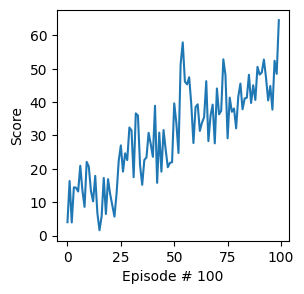

Episode 199	 Current Avg Score: 46.51 	Average Score in Queue: 57.61

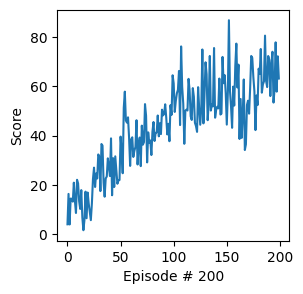

Episode 299	 Current Avg Score: 64.65 	Average Score in Queue: 80.80

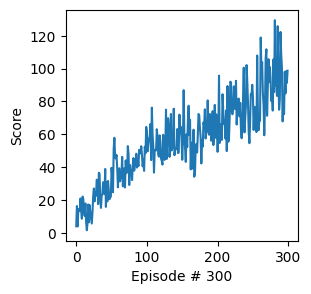

Episode 357	 Current Avg Score: 72.31 	Average Score in Queue: 92.258

In [ ]:
agent = Agent(state_size=state_size, action_size=action_size, num_agents = num_agents, random_seed=100)
scores = ddpg_multi_agents(agent)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111) 
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score') 
plt.xlabel('Episode #')
plt.show()

# See Smart Agent

In [ ]:
from unityagents import UnityEnvironment
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim
import sys 
from scripts.model import Actor, Critic
from scripts.agent import Agent
import time
import copy
from matplotlib.pylab import plt
%load_ext autoreload
%autoreload 2

In [ ]:
gym_name = "Crawler"
env_name = "gym/" + gym_name + ".app"

env = UnityEnvironment(file_name=env_name, base_port=64738, worker_id=3, seed=0, no_graphics=False)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

In [ ]:
agent = Agent(state_size=state_size, action_size=action_size, num_agents = num_agents, random_seed=100)

# Load trained weights
agent.critic_local.load_state_dict(torch.load('model/' + gym_name + '_checkpoint_critic.pth'))
agent.actor_local.load_state_dict(torch.load('model/' + gym_name + '_checkpoint_actor.pth'))


env_info = env.reset(train_mode=False)[brain_name]     
states = env_info.vector_observations                  
all_scores = []
count = 0
while True:
    scores = np.zeros(num_agents)   

    actions = agent.act(states)                     
    env_info = env.step(actions)[brain_name]          
    next_states = env_info.vector_observations       
    rewards = env_info.rewards                        
    dones = env_info.local_done                        
    scores += env_info.rewards  
    all_scores.append(scores)
    states = next_states    
    
    if np.any(dones):   
        count += 1
    if count < 3:
        count -=1
    if count > 15:
        break

env.close()